In [36]:
import os
from collections import OrderedDict
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, \
                            pairwise_distances, \
                            mean_squared_error
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda

np.random.seed(129)

# FashionMNIST

In [2]:
training_data = datasets.FashionMNIST(
    root="../data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="../data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [3]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


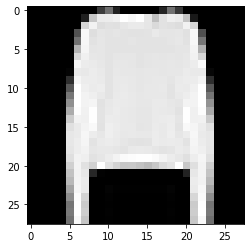

Label: 2


In [4]:
# Display image and label.
batch_x, batch_y = next(iter(train_dataloader))
print(f"Feature batch shape: {batch_x.size()}")
print(f"Labels batch shape: {batch_y.size()}")
img = batch_x[0].squeeze()
label = batch_y[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [5]:
dim_num = training_data[0][0].size()[1] *  training_data[0][0].size()[2]
dim_num

784

# Define Network(s)

In [145]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

class NeuralNetwork(nn.Module):
    def __init__(self, n_hidden=256):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(dim_num, n_hidden),
            nn.ReLU(),
            #nn.Dropout(.1),
            #nn.Linear(n_hidden, n_hidden),
            #nn.ReLU(),
            #nn.Dropout(.1),
            nn.Linear(n_hidden, 10),
            #nn.Softmax(-1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
def getNeuralNet(dim_num=784, n_hidden=256, n_classes=10):
    return nn.Sequential(
        OrderedDict(
            [
                ("flatten", nn.Flatten()),
                ("layer_1_linear", nn.Linear(dim_num, n_hidden)),
                ("layer_1_act", nn.ReLU()),
                # ("layer_1_dropout", nn.Dropout(.1)),
                ("layer_2_linear", nn.Linear(n_hidden, n_hidden)),
                ("layer_2_act", nn.ReLU()),
                # ("layer_2_dropout", nn.Dropout(.1)),
                ("output", nn.Linear(n_hidden, n_classes)),
            ]
        )
    )

Using cpu device


In [146]:
# two networks of different sizes to be trained
net1 = getNeuralNet(dim_num, 64, 10)
net2 = getNeuralNet(dim_num, 16, 10)
# another network to stay randomly initialized
net3 = getNeuralNet(dim_num, 16, 10) 

In [147]:
#for name, param in model.named_parameters():
#    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

In [148]:
learning_rate = 1e-3
#batch_size = 64
epochs = 4
loss_fn = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(net1.parameters(), lr=learning_rate)
optimizer2 = torch.optim.Adam(net2.parameters(), lr=learning_rate)

# Training

In [149]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader)
    train_losses = []
    for step, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
    return np.mean(train_losses)


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    predictions = []
    
    with torch.no_grad():
        for X,y in dataloader:
            # Compute prediction and loss
            pred = model(X)
            predictions.append(pred)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return predictions

In [150]:
losses1, losses2 = [], []
from rich.progress import track
for t in range(epochs):
    print("Epoch {}/{}".format(t+1,epochs))
    losses1.append(train_loop(train_dataloader, net1, loss_fn, optimizer1))
    losses2.append(train_loop(train_dataloader, net2, loss_fn, optimizer2))
    #test_loop(test, test_labels, model, loss_fn)
print("Done!")

Epoch 1/4
Epoch 2/4
Epoch 3/4
Epoch 4/4
Done!


In [151]:
predictions1 = test_loop(test_dataloader, net1, loss_fn)
predictions2 = test_loop(test_dataloader, net2, loss_fn)
predictions3 = test_loop(test_dataloader, net3, loss_fn)

Test Error: 
 Accuracy: 86.6%, Avg loss: 0.005811 

Test Error: 
 Accuracy: 84.0%, Avg loss: 0.007023 

Test Error: 
 Accuracy: 7.9%, Avg loss: 0.036380 



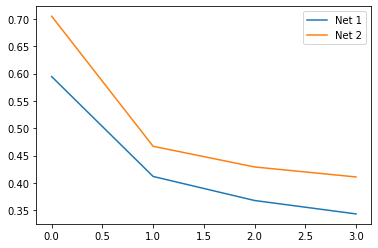

In [152]:
import matplotlib.pyplot as plt
plt.plot(losses1, label='Net 1')
plt.plot(losses2, label='Net 2')
plt.legend()
plt.show()

### Get a copy of net2 with weights scaled 10x

In [168]:
net2b = getNeuralNet(dim_num, 16, 10)

In [169]:
weights = net2[1].weight.detach().numpy() * 10
with torch.no_grad():
    net2b[1].weight.copy_(torch.tensor(weights, requires_grad=True))

In [170]:
print(net2[1].weight)
print(net2b[1].weight)

Parameter containing:
tensor([[-0.0312,  0.0190,  0.0236,  ...,  0.0140,  0.0233, -0.0135],
        [ 0.0173,  0.1364,  0.1894,  ...,  0.1279, -0.0563, -0.0276],
        [-0.1722, -0.0401, -0.1826,  ..., -0.1344, -0.2593, -0.2280],
        ...,
        [-0.1324, -0.0009, -0.1628,  ...,  0.2109,  0.2315,  0.0659],
        [-0.0676, -0.1038, -0.2779,  ..., -0.0724,  0.0392,  0.0660],
        [ 0.0241,  0.0121,  0.0293,  ..., -0.0163, -0.0024,  0.0200]],
       requires_grad=True)
Parameter containing:
tensor([[-0.3122,  0.1899,  0.2359,  ...,  0.1403,  0.2328, -0.1348],
        [ 0.1731,  1.3643,  1.8936,  ...,  1.2794, -0.5631, -0.2759],
        [-1.7218, -0.4010, -1.8260,  ..., -1.3436, -2.5933, -2.2795],
        ...,
        [-1.3237, -0.0088, -1.6281,  ...,  2.1092,  2.3148,  0.6588],
        [-0.6759, -1.0382, -2.7788,  ..., -0.7237,  0.3916,  0.6596],
        [ 0.2411,  0.1210,  0.2934,  ..., -0.1633, -0.0240,  0.2004]],
       requires_grad=True)


# Embeddings

In [171]:
net1

Sequential(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_1_linear): Linear(in_features=784, out_features=64, bias=True)
  (layer_1_act): ReLU()
  (layer_2_linear): Linear(in_features=64, out_features=64, bias=True)
  (layer_2_act): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
)

In [172]:
# Define function to get subnet from given network at index
def get_subnet(parent_net, break_layer_idx = '1'):
    children_list = []
    for n,c in parent_net.named_children():
        children_list.append(c)
        if n == break_layer_idx:
            break
    sub_net = nn.Sequential(*children_list)
    return sub_net

In [173]:
# Print one of the original networks as reference
#net1

In [174]:
# Get the subnetworks
sub_net1 = get_subnet(net1, 'layer_1_act')
sub_net2 = get_subnet(net2, 'layer_1_act')
sub_net2b= get_subnet(net2b, 'layer_1_act')
sub_net3 = get_subnet(net3, 'layer_1_act')

In [175]:
#sub_net1

In [176]:
# Get DataLoader with larger batch_size
dl = DataLoader(training_data, batch_size=400, shuffle=False)
batch_x, batch_y = next(iter(dl))

In [177]:
# Get embeddings for batch
emb1 = sub_net1(batch_x).detach().numpy()
emb2 = sub_net2(batch_x).detach().numpy()
emb2b= sub_net2b(batch_x).detach().numpy()
emb3 = sub_net3(batch_x).detach().numpy()

In [178]:
emb1.shape,emb2.shape,emb3.shape

((400, 64), (400, 16), (400, 16))

In [179]:
# Get t-SNE embeddings for the outputs
from sklearn.manifold import TSNE
tsne1 = TSNE(n_components=2).fit_transform(emb1)
tsne2 = TSNE(n_components=2).fit_transform(emb2)
tsne2b= TSNE(n_components=2).fit_transform(emb2b)
tsne3 = TSNE(n_components=2).fit_transform(emb3)

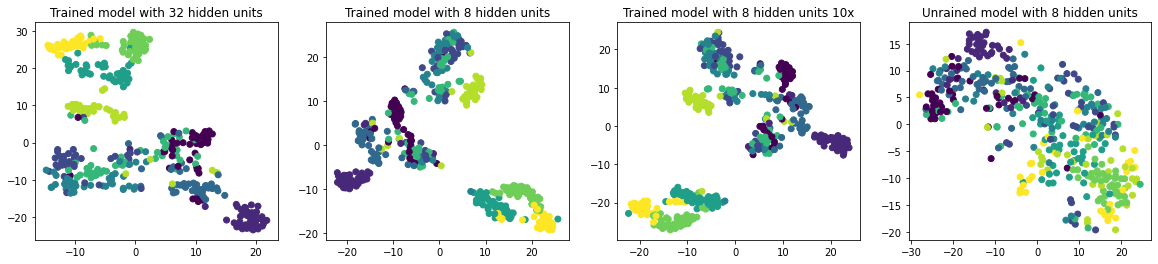

In [180]:
plt.figure(figsize=(20,4))

plt.subplot(141)
plt.title('Trained model with 32 hidden units')
plt.scatter(tsne1[:,0], tsne1[:,1], c=batch_y)

plt.subplot(142)
plt.title('Trained model with 8 hidden units')
plt.scatter(tsne2[:,0], tsne2[:,1], c=batch_y)

plt.subplot(143)
plt.title('Trained model with 8 hidden units 10x')
plt.scatter(tsne2b[:,0], tsne2b[:,1], c=batch_y)

plt.subplot(144)
plt.title('Unrained model with 8 hidden units')
plt.scatter(tsne3[:,0], tsne3[:,1], c=batch_y)

plt.show()

# Embedding Fitness

In [181]:
import sys
sys.path.append('..')
from losses import DistanceLoss, TSNELoss
from utils import measure_exec_time

In [182]:
tsne_loss = TSNELoss(emb1, use_gaussians=True)

In [183]:
loss_val = tsne_loss(emb2)
print(loss_val)

0.9192094215124652


In [184]:
loss_val = tsne_loss(emb2 * 1000)
print(loss_val)

0.9571073415595678


In [185]:
loss_val = tsne_loss(emb3)
print(loss_val)

2.0428094661993588


In [186]:
measure_exec_time(tsne_loss, emb2)

Execution took 4.384054899215698 seconds


In [111]:
measure_exec_time(dist_loss, [emb1], [emb2])

Execution took 0.31470394134521484 seconds


In [100]:
dist_loss = DistanceLoss()

In [101]:
dist_loss([emb1], [emb2])

0.004820520058274269

In [102]:
dist_loss([emb1], [emb3])

0.01219495665282011



---



In [22]:
EPSCUT = np.finfo(np.double).eps

In [7]:
#euclid = lambda x,y: np.linalg.norm(x-y,ord=2)

def p_j_i(embeddings, j, i):
    
    p_func = lambda xj,xi: 
        np.exp(-paired_distances([xi], [xj])**2 / 2*sigmai2)
    
    q_func = lambda xj,xi:
        1 / np.max(1 + paired_distances([xi],[xj])**2, EPSCUT)
    
    nominator = q_func(embeddings[j], embeddings[i])
    
    denominator = np.sum([
        q_func(embeddings[k], embeddings[i])
            for k in range(len(embeddings)) if k != i
    ])
    
    return nominator / denominator

def pij(embeddings, i, j):
    N = len(embeddings)
    return (p_j_i(embeddings, j, i) + p_j_i(embeddings, i, j)) / 2*N